### Batch selection

#### This is the second step of the enrichment calculation

Batching experiments by overall similarity in intensity correlations. Background noise in experiments drift over a time, and batching by correlation allows more accurate significance testing.  
Recognizing batches is performed by calculating correlations between wildtype samples.
For some experiments that do not have wildtypes, WT is simulated by taking the median of all samples within the experiments

In [3]:
import os, sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

script_path = Path.cwd().parent.parent / "script"
data_path = Path.cwd().parent.parent / "data"
sys.path.append(str(script_path))

from pyseus import basic_processing as ip
from pyseus import contrast_tools as ct

### Load the imputed IP table
NOTE: the correct datestamp is required to find the input files

In [4]:
%store -r timestamp USE_FROZEN
if USE_FROZEN:
    raise Exception("USE_FROZEN is true, you probably want to skip enrichment and proceed from Fig1")
print(f"Timestamp: {timestamp}")

maxQuant_csv = "proteinGroups_2023-02-08_big_quant.txt"
outprefix = f"{timestamp}_QC_filter_impute"

outdir = Path.cwd() / "output"
preprocessing_out = outdir / f"preprocessing"

Timestamp: 2023-12-04


In [5]:
#### Load bait imputed tables (IPs)
IP_path = preprocessing_out / f"{outprefix}_imputed_table.csv"

try:
    bait_imputed_table = pd.read_csv(IP_path, header=[0, 1], index_col=0)
except FileNotFoundError:
    print(f"File {IP_path} not found.\nPlease run 1.QC_filter_and_impute.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {IP_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### Batch selection using the IP samples

In [6]:
# Here we're not using each replicate, just medians of replicates. Calculate the median. 
medians = ip.median_replicates(bait_imputed_table, save_info=False)

# Find WT cols (also not infected)
wt_cols = [x for x in list(medians) if 'WT' in x and 'Harsh' not in x and 'harsh' not in x and 'infected' not in x and 'Infected' not in x and '_infected' not in x and 'arsenite' not in x and 'brefeldin' not in x]

# for IP06 and IP11 that do not have WT sample, we create a median out of all the samples in the experiment
# to simulate a WT
ip06s = [x for x in list(medians) if '06-' in x]
ip11s = [x for x in list(medians) if '11-' in x]

ip06_median = medians[ip06s].median(axis=1)
ip11_median = medians[ip11s].median(axis=1)

# collection of all wildtypes (including simulated)
wildtypes = medians[wt_cols].copy()
wildtypes['IP06-sim_WT'] = ip06_median.to_list()
wildtypes['IP11-sim_WT'] = ip11_median.to_list()

# sort cols 
wt_sort = list(wildtypes)
wt_sort.sort()
wildtypes = wildtypes[wt_sort].copy()


In [7]:
# check WT columns
wildtypes

,01-WT,02-WT,03-WT,04-WT,05-WT,07-WT,09-WT,10-WT,12-WT,13-WT,14-WT,15-WT,17-WT,IP06-sim_WT,IP11-sim_WT
0,20.434781,19.282617,18.683539,19.263736,21.837600,20.005500,21.289100,21.977100,19.632423,18.700846,21.834400,20.837300,19.583865,21.746100,18.462138
1,26.047200,24.854900,26.330400,26.652000,26.033100,25.616000,27.783500,27.918600,27.155800,27.607300,25.977200,25.798100,26.472100,26.022700,25.851200
2,23.255800,23.831700,21.399900,24.019500,23.159800,22.600300,23.813400,23.504000,19.372200,19.475968,24.704100,24.000800,23.432500,24.743900,24.494200
3,19.655653,19.161352,17.914656,18.181174,18.383678,18.904945,18.517629,19.054401,20.136641,18.711910,18.779125,18.376371,19.365224,18.578414,18.293769
4,25.245500,26.383800,25.086400,25.437800,25.665200,24.752000,25.899000,26.034900,19.275554,17.731640,25.221500,25.578900,23.859000,26.356000,27.893000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8594,18.380474,18.708344,18.472960,17.665689,19.528003,18.002196,19.595273,18.376193,18.331176,18.119037,18.301069,18.788376,18.623759,18.493949,19.006621
8595,19.297130,19.053202,18.228012,18.610474,20.005448,22.022200,18.881345,19.552091,19.121001,17.822958,22.491600,22.404000,18.939046,19.452756,20.663400
8596,18.120734,18.444309,19.258896,19.784325,20.401656,19.137521,18.443837,19.462072,18.624960,18.880560,18.749622,18.881018,18.750667,19.251944,18.672042
8597,18.730629,19.812255,19.107935,17.567962,19.345872,19.676367,19.655543,21.027820,19.913216,18.386244,18.764171,18.060535,19.034617,19.695749,19.220541


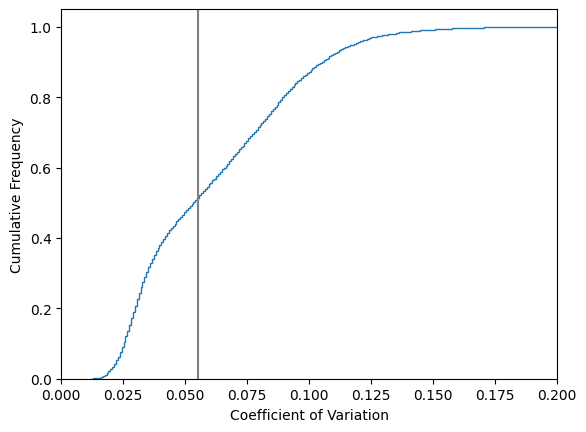

In [8]:
# To get a higher resolution of variance between wildtypes, remove proteins that do not change across WTs
# Calculate the Coefficient of Variation for the filter.
stdevs = wildtypes.std(axis=1)
means = wildtypes.mean(axis=1)
coefs = stdevs / means

# Plot distribution of Coefficients of Variation
fig = coefs.plot.hist(bins=300, histtype="step", cumulative=True, density=True)
fig.set_xlim([0, 0.2])
fig.axvline(x=0.055, color="grey")
fig.set_xlabel("Coefficient of Variation")
_ = fig.set_ylabel("Cumulative Frequency")

# threshold at 0.005 is just below 50% of all proteins - meaning these proteins are relatively static
# and will be filtered out.
filtered = coefs[coefs >= 0.055]
filt_idx = filtered.index.to_list()
wildtype_filtered = wildtypes.loc[filt_idx].copy()

# 3771 more varying proteins out of 8574 left
wildtype_filtered.shape

# adding standard header for the next set
wildtype_final = ct.standard_pyseus_headers(wildtype_filtered)

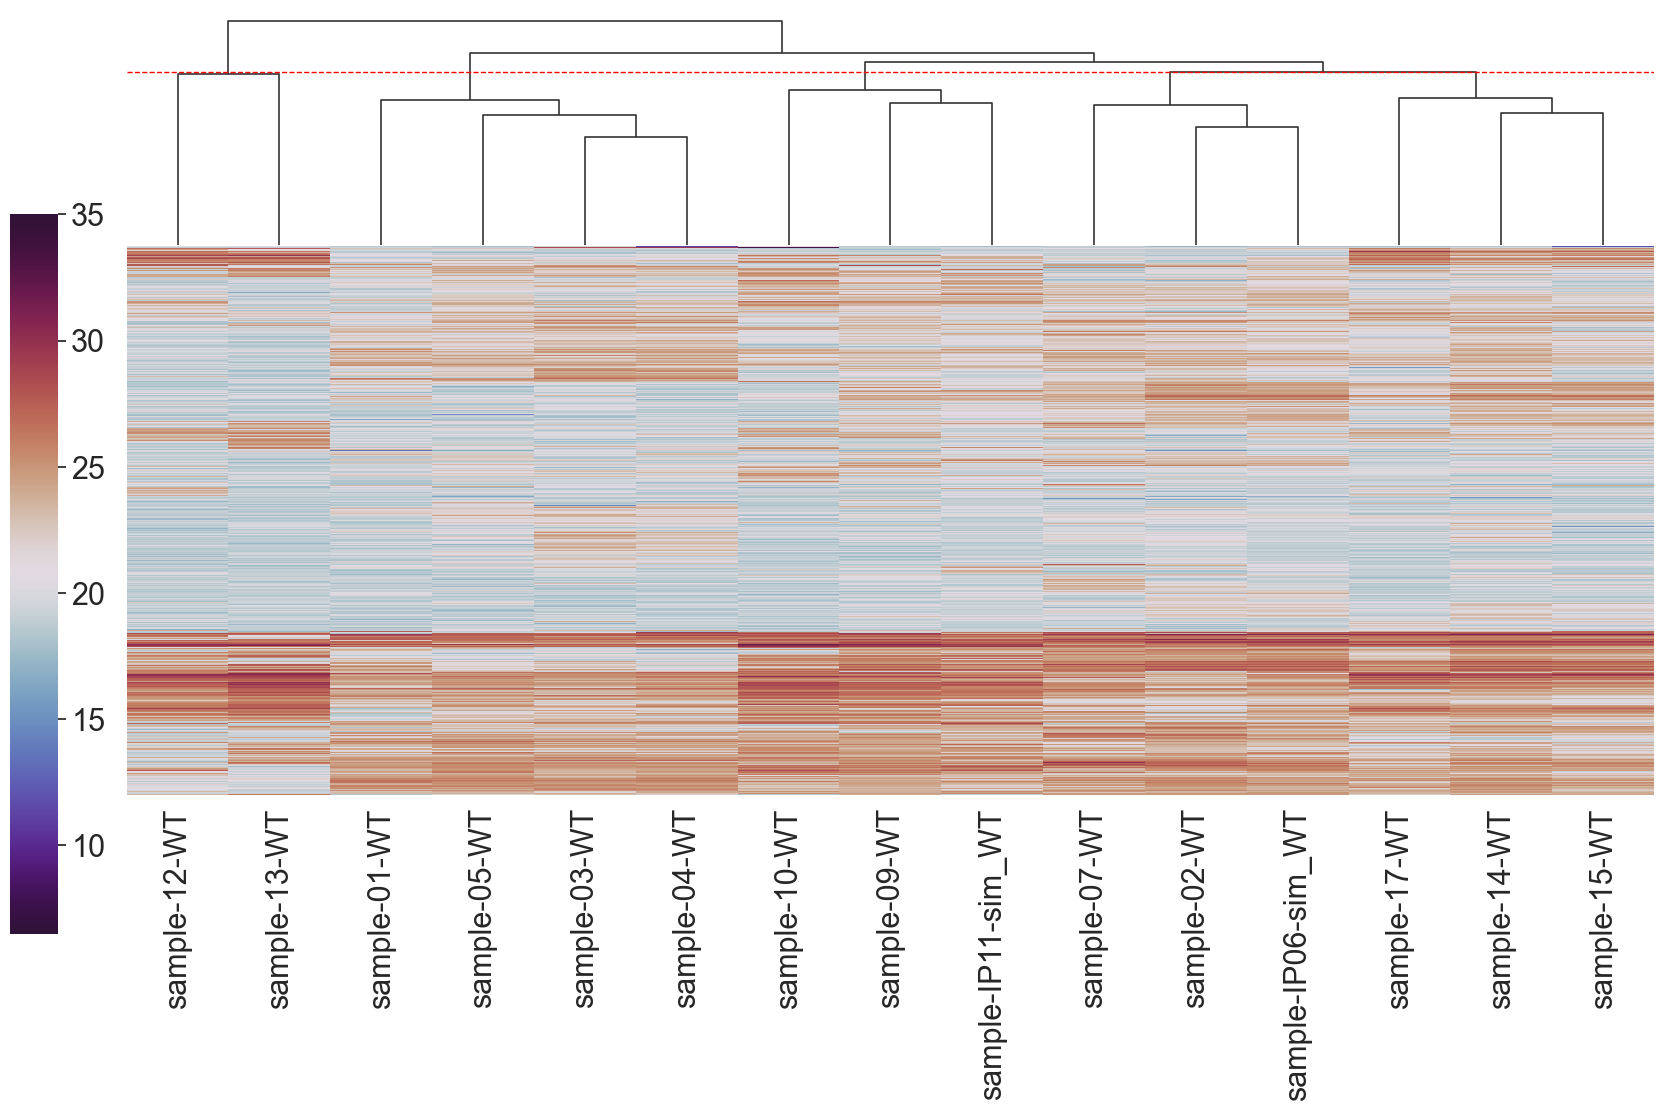

In [9]:
# clustermap to show the hierarchical clustering of the WTs (low_variance proteins removed)
sns.set(font_scale=2)
g = sns.clustermap(wildtype_final, cmap='twilight_shifted', figsize=(16,12), 
                   metric="euclidean", method="average", 
                   dendrogram_ratio=(0,0.3), cbar_pos=(-0.05, 0.20, 0.03, 0.6), tree_kws=dict(linewidths=1.2),
                   yticklabels=False)
g.ax_heatmap.set_xlabel('')
g.ax_col_dendrogram.axhline(y=166, color='red', linewidth=1, linestyle='--')

plt.show()

In [10]:
batches = [
    ["12", "13"],
    ["01", "03", "04", "05"],
    ["02", "06", "07"],
    ["14", "15", "17"],
    ["09", "10", "11"],
]